In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"
    seed: int = 42
    test_size: float = 0.2


config = Config()

sys.path.append(str(config.REPO_ROOT))

In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)
from sklearn.svm import SVR

df_bike = pd.read_csv(config.data_dir / "bike-sharing-daily.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

df_bike_processed["holiday"] = df_bike_processed["holiday"].map(
    {"HOLIDAY": 1, "NO HOLIDAY": 0}
)
df_bike_processed["season"] = df_bike_processed["season"].map(
    {
        "WINTER": 1,
        "SPRING": 2,
        "SUMMER": 3,
        "FALL": 4,
    }
)
df_bike_processed["workingday"] = df_bike_processed["workingday"].map(
    {"WORKING DAY": 1, "NO WORKING DAY": 0}
)
df_bike_processed["mnth"] = df_bike_processed["mnth"].map(
    {
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12,
    }
)
df_bike_processed["weekday"] = df_bike_processed["weekday"].map(
    {
        "SUN": 1,
        "MON": 2,
        "TUE": 3,
        "WED": 4,
        "THU": 5,
        "FRI": 6,
        "SAT": 7,
    }
)
df_bike_processed["weathersit"] = df_bike_processed["weathersit"].map(
    {"MISTY": 1, "GOOD": 2, "RAIN/SNOW/STORM": 3}
)
X = df_bike_processed.drop(columns="cnt")
y = df_bike_processed["cnt"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.test_size, random_state=config.seed
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index
)


In [3]:
svr = SVR()
svr.fit(X_train_scaled, y_train)
svr_predictions = svr.predict(X_train_scaled)
tree_surrogate = DecisionTreeRegressor(max_depth=2)
tree_surrogate.fit(X_train, svr_predictions)
surrogate_predictions = tree_surrogate.predict(X_train)

r_squared = r2_score(svr_predictions, surrogate_predictions)
print(f"R-squared of the surrogate model (Train): {r_squared:.2f}")

svr_predictions_test = svr.predict(X_test_scaled)
surrogate_predictions_test = tree_surrogate.predict(X_test)
r_squared_test = r2_score(svr_predictions_test, surrogate_predictions_test)
print(f"R-squared of the surrogate model (Test): {r_squared_test:.2f}")


R-squared of the surrogate model (Train): 0.80
R-squared of the surrogate model (Test): 0.75


In [4]:
n_nodes = tree_surrogate.tree_.node_count
children_left = tree_surrogate.tree_.children_left
children_right = tree_surrogate.tree_.children_right
feature = tree_surrogate.tree_.feature
threshold = tree_surrogate.tree_.threshold
value = tree_surrogate.tree_.value

leaf_nodes = np.where(children_left == children_right)[0]
for leaf_node in leaf_nodes:
    print(f"Leaf Node: {leaf_node}")
    print(f"  Prediction value: {value[leaf_node][0][0]:.2f}")


def get_rule(leaf_node, feature_names):
    rule = []
    current_node = leaf_node

    while current_node != 0:
        parent_node = np.where(
            (children_left == current_node) | (children_right == current_node)
        )[0][0]
        if current_node == children_left[parent_node]:
            rule.insert(
                0,
                f"{feature_names[feature[parent_node]]} <= {threshold[parent_node]:.2f}",
            )
        else:
            rule.insert(
                0,
                f"{feature_names[feature[parent_node]]} > {threshold[parent_node]:.2f}",
            )
        current_node = parent_node
    return " and ".join(rule)


feature_names = X.columns.tolist()
for leaf_node in leaf_nodes:
    rule = get_rule(leaf_node, feature_names)
    print(f"  Rule: {rule}")

Leaf Node: 2
  Prediction value: 4542.00
Leaf Node: 3
  Prediction value: 4572.58
Leaf Node: 5
  Prediction value: 4595.50
Leaf Node: 6
  Prediction value: 4620.45
  Rule: days_since_2011 <= 443.00 and days_since_2011 <= 138.50
  Rule: days_since_2011 <= 443.00 and days_since_2011 > 138.50
  Rule: days_since_2011 > 443.00 and temp <= 15.97
  Rule: days_since_2011 > 443.00 and temp > 15.97


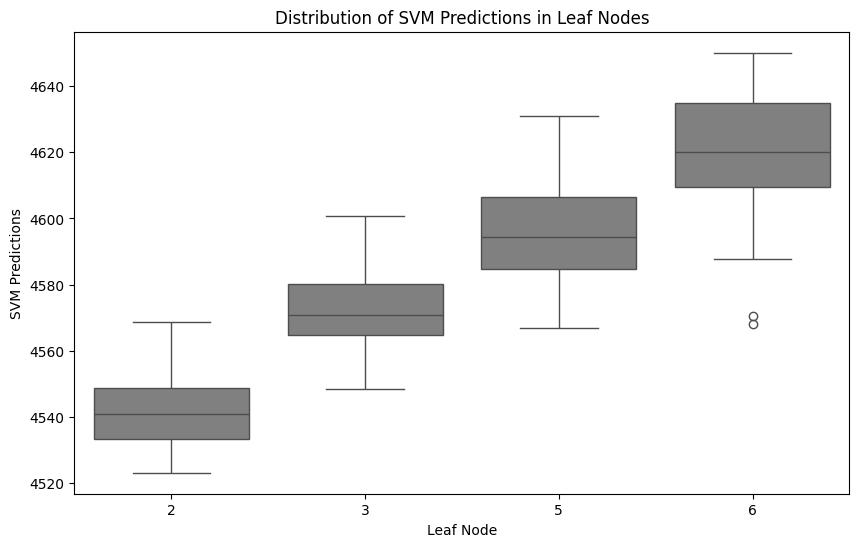

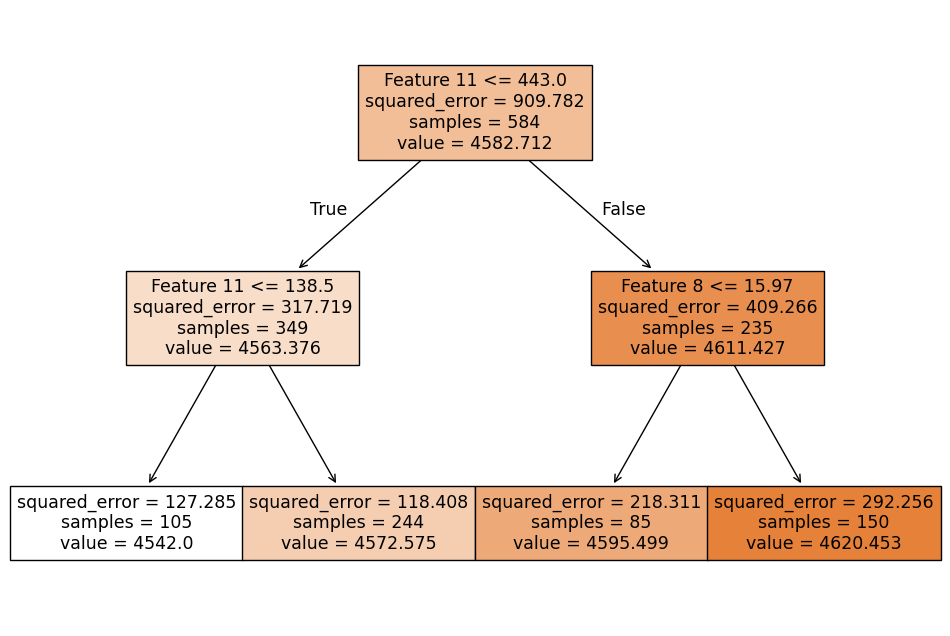

In [6]:
leaf_indices = tree_surrogate.apply(X_train)
plot_df = pd.DataFrame({"leaf": leaf_indices, "svm_predictions": svr_predictions})

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x="leaf", y="svm_predictions", data=plot_df, ax=ax, color="gray")
ax.set_xlabel("Leaf Node")
ax.set_ylabel("SVM Predictions")
ax.set_title("Distribution of SVM Predictions in Leaf Nodes")
plt.show()


fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(
    tree_surrogate,
    filled=True,
    ax=ax,
    feature_names=[f"Feature {i + 1}" for i in range(X.shape[1])],
)
plt.show()

In [7]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]

X = df_rfcc_preprocessed.drop("Biopsy", axis=1)
y = df_rfcc_preprocessed["Biopsy"].map({"Healthy": 0, "Cancer": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.test_size, random_state=config.seed
)


rf_model = RandomForestClassifier(random_state=config.seed)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf_predictions = rf_model.predict(X_train)
tree_surrogate = DecisionTreeRegressor(max_depth=2)
tree_surrogate.fit(X_train, rf_predictions)
surrogate_predictions = tree_surrogate.predict(X_train)
r_squared = r2_score(rf_predictions, surrogate_predictions)
print(f"R-squared of the surrogate model (Train): {r_squared:.2f}")

rf_predictions_test = rf_model.predict(X_test)
surrogate_predictions_test = tree_surrogate.predict(X_test)
r_squared_test = r2_score(rf_predictions_test, surrogate_predictions_test)
print(f"R-squared of the surrogate model (Test): {r_squared_test:.2f}")

R-squared of the surrogate model (Train): 0.06
R-squared of the surrogate model (Test): 0.00


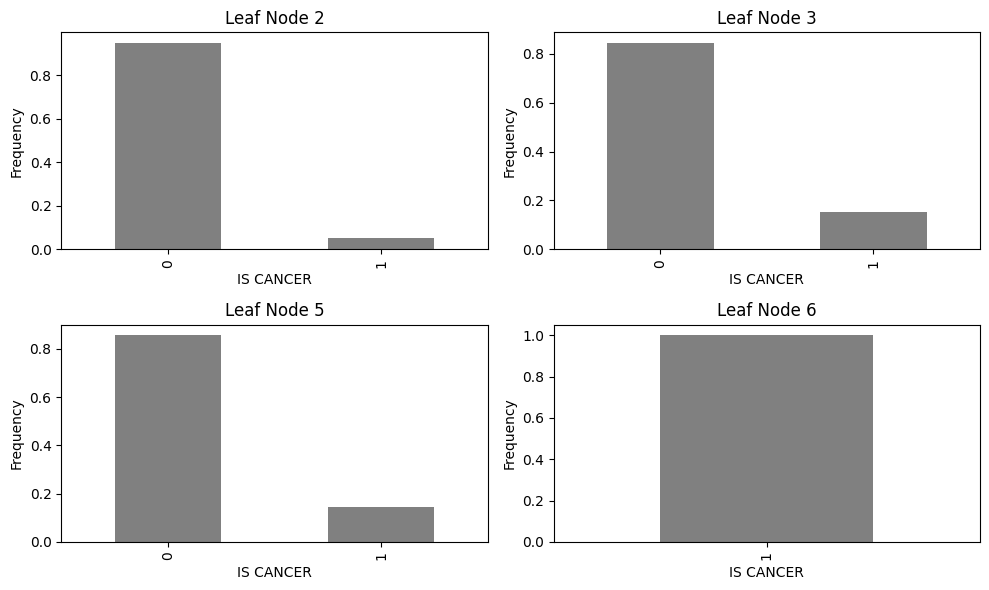

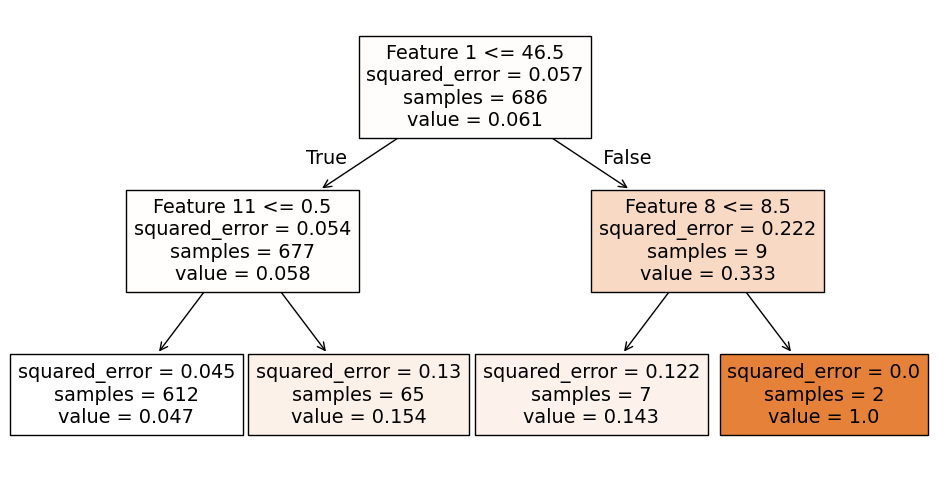

In [16]:
leaf_indices = tree_surrogate.apply(X_train)
plot_df = pd.DataFrame({"leaf": leaf_indices, "is_cancer": y_train})
plot_df["is_cancer"] = plot_df["is_cancer"].astype(int)

n_leaves = len(plot_df["leaf"].unique())
n_cols = 2
n_rows = (n_leaves + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.ravel()

for i, leaf in enumerate(sorted(plot_df["leaf"].unique())):
    ax = axes[i]
    leaf_data = plot_df.query("leaf==@leaf")["is_cancer"].value_counts(normalize=True)
    leaf_data.plot(kind="bar", ax=ax, color="gray")
    ax.set_title(f"Leaf Node {leaf}")
    ax.set_xlabel("IS CANCER")
    ax.set_ylabel("Frequency")


for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plot_tree(
    tree_surrogate,
    filled=True,
    ax=ax,
    feature_names=[f"Feature {i + 1}" for i in range(X.shape[1])],
)
plt.show()